<h2><b>Heisenberg Model: Ground-State Energy Estimation</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><u>1. Overview</u></h3>

This notebook demonstrates how `pyLIQTR` can perform qubitized ground-state energy estimation for Heisenberg-type spin models..   Our target is a two-dimensional square lattice, though our framework extends to arbitrary symmetries and dimensionality (see the general spin models exmple). A realistic workflow  also requires components initial state preparation $-$ a starting "guess" $-$ which may be the ground state of a classically-solvable quadratic / mean-field Hamiltonian.  These tasks are demonstrated in a separate notebook.

<hr></hr>

<h3><u>2. Background</u></h3>

This example addresses the Heisenberg model on an arbitrary 2d or 3d lattice:

\begin{equation}
H =   \sum_{\mu, \langle p, q \rangle} J^\mu{p,q}\, (\sigma^\mu{p} \otimes \sigma^\mu{q}) + \sum_{\mu, p} h^{\mu}_{p} \, \sigma^\mu{p}.
\end{equation}

Our notation labels lattice sites using composite indices $p,q$ and writes angle brackets denote summation over nearest-neighbor spatial pairs. Folowing common notation, the index $\mu \in \{x,y,z\}$ specifies the Pauli operators $\sigma^\mu$. The first term in this Hamiltonian gives a bilinear spin-spin coupling of strength $J^\mu{p,q}$ and the second local fields of magnitude $ h^{\mu}_{p}$. 

While this model is two- or three-dimensional, our qubit registers are often specified as a one-dimensional array.  Fortunately, it is a simple matter to rephrase a higher-dimensional Hamiltonian as a one-dimensional system with long-range spin couplings.  We accomplish this by define a one-dimensional  path that snakes through the lattice:

<figure>
<center><img src = "./figures/heis_2d_mapping.png" width=900></center>
</figure>

This provides nearest-neighbor interactions within a row and longer-range, yet fixed-distance (specifically $N-1$), couplings down the columns of the lattice.  When recast in this manner the Hamiltonian becomes:

\begin{equation}
H = \sum_{\mu \in \{x,y,z\}} H_\mu,
\end{equation}

with the constituent terms,

\begin{equation}
H_\alpha =  \sum_{k=1}^{N(M-1)} J^\alpha \sigma^\alpha_k \otimes \sigma^\alpha_{k+N} + \sum_{j=0}^{M-1} \sum_{k=1}^{N-1} J^\alpha \sigma^\alpha_{j N + k} \otimes \sigma^\alpha_{j N + k + 1} + \sum_{k=1}^{N M} h^\alpha \sigma^\alpha_k.
\end{equation}

The same approach extends directly to 3d.  In this case we define a zigzag path through each 2d slice and assocaite the endpoint of this path in one slice with the beginning of a path through the next.




<hr>

<h3><u>3. Computational Methods</u></h3>

Our previous notebook introduced the Heisenberg model in terms of qubits.  We do not repeat those details, but instead focus on the aspects of quantum simulation.  

Ground-state energy estimation is a particular limit of state preparation. Stated broadly, state preparation algorithms aim to converge initial wavefunction to a designated eigenstate of some Hamiltonian (up to a defined precision).  Our desired outputs will dictate algorithm selection: in some cases we only require an energy eigenvalue while  in others we must coherently prepare a state for subsequent calculations.  Our presentation will emphasize a Heisenberg-limited GSEE strategy that uses qubitization to achieve linear $T$-count scaling in problem size.  This method can also be made coherent for state preparation with subsequent oblivious amplitude amplification steps.

<h5><b>Ground-State Energy Estimation (GSEE)</b></h5>

Many ground-state estimation protocols are based on the quantum phase estimation algorithm.  Our algorithm is no exception, though it queries powers of a qubitized walk $W$ operator in lieu of the standard time evolution oracle.  This operator contains a block encoding of our Hamiltonian $H$, which is handled using a $\text{Prepare}^{-1} \cdot \text{Select} \cdot \text{Prepare}$ oracle sequence. The eigenphases $\phi_k$ of $W$ have a simple functional relation with the eigenenergies $E_k$ of $H$,  allowing us to extract the latter using phase estimation:

\begin{equation}
\phi_k \approx e^{\imath \text{arccos} (E_k / \alpha) \cdot \hat{Y}}
\end{equation}

where $\alpha$ is a normalization factor that makes the block encoding unitary (i.e., actually we block-encode $H/\alpha$). 



 <center><img src="./figures/qubitized_phase_estimation.png" width=1100></img></center>


Phase readout is accomplished through a set of $d$ precision bits, either using a quantum Fourier transform or an iterative approach.  The number of required bits is related to the error in energy by,

\begin{equation}
d = {\biggl \lceil} \log \bigg(\frac{\sqrt{2} \pi \alpha}{2 \Delta E} \bigg)\biggr \rceil,
\end{equation}

where $\alpha$ is the normalization factor for the block encoding scheme.  Choosing the number of bits at or below this bound will give 

<h3><u>4. Quantum Algorithms</u></h3>

`pyLIQTR` provides several quantum simulation methods can be used with the Heisenberg model.  We describe these and provide demonstration code below.

In [2]:

import  numpy                  as   np
import  matplotlib.pyplot      as   plt

from    qualtran.cirq_interop.jupyter_tools  import  svg_circuit
from    scipy.optimize               import  curve_fit

# Circuit decomposition
##
from    pyLIQTR.utils.circuit_decomposition                   import   circuit_decompose_multi      

## Problem instance & Encoding items
##
from    pyLIQTR.ProblemInstances.getInstance                  import   getInstance
from    pyLIQTR.clam.lattice_definitions                      import   CubicLattice, SquareLattice, TriangularLattice
from    pyLIQTR.BlockEncodings.getEncoding                    import   getEncoding, VALID_ENCODINGS

## Walk operator and phase estimation
##
from    pyLIQTR.qubitization.qubitized_gates                  import   QubitizedWalkOperator
from    pyLIQTR.qubitization.phase_estimation                 import   QubitizedPhaseEstimation

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis                        import   estimate_resources

## OpenQASM Export
##
from   pyLIQTR.utils.printing                                 import openqasm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<h4><b>4.1. GSEE Calculations: Introduction </b></h4> 


We will demonstrate how to assemble GSEE calculations for a small, two-dimensional  instance of the Heisenberg XXZ model.  We instantiate the problem with couplings $J_x = J_y = J = J_z/2$ and fields $h_x = -J_z$, $h_z = -J_z/2$.  The coupling $J_z$ defines set a characteristic energy scale for the model:

\begin{equation}
H =   \sum_{\langle p, q \rangle} \big[J (X_p \otimes X_q + Y_p \otimes Y_q ) + J Z_p \otimes Z_q\big] + \sum_{ p}  (h_x X_p + h_z Z_p)
\end{equation}

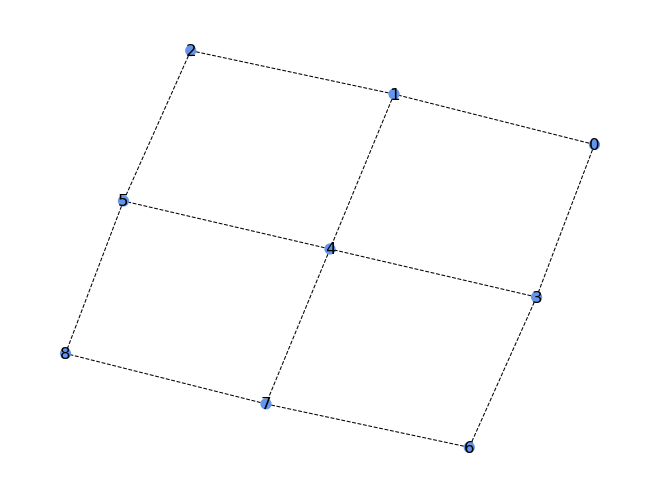

In [3]:
N=3

J_x = J_y = -0.5;                J_z = -1.0
h_x = 1.0;      h_y = 0.0;       h_z = 0.5

model  =  getInstance( "Heisenberg", 
                       shape=(N,N), 
                       J=(J_x,J_y,J_z), 
                       h=(h_x,h_y,h_z), 
                       cell=SquareLattice )

model.draw_lattice()

Next, we select a block encoding the Hamiltonian.  We will use a conventional Select-Prepare sequence based on a linear combination of unitaries (LCU).  

In [4]:
block_encoding    =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)

The normalization factor for the `PauliLCU` encoding matches the 1-norm of the Hamiltonian:

In [4]:
block_encoding.alpha

37.5

The leading overhead from this method comes from the walk operator, which we can assemble and assess in isolation:

In [5]:
walk_operator  =  QubitizedWalkOperator( getEncoding(VALID_ENCODINGS.PauliLCU), instance=model)

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision.

In [6]:
resource_estimate_block  =  estimate_resources(block_encoding)
print(resource_estimate_block)

{'LogicalQubits': 15, 'T': 13432, 'Clifford': 27773}


In [7]:
resource_estimate_walk  =  estimate_resources(walk_operator)
print(resource_estimate_walk)

{'LogicalQubits': 16, 'T': 13456, 'Clifford': 27877}


Note that estimate resources has two keyword arguments that control $T$-synthesis.  The first is `rotation_gate_precision` (default `= 1e-10`), which specifies the maximum approximation error each rotation.  The second is `circuit_precision`, which overrides `rotation_gate_precision` if specified and sets the maximumum approximation error to `circuit_precision` / $N_\text{gates}$, where $N_\text{gates}$ is the number of rotation gates in a given circuit element.

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `cirq-ft` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show supported levels of decompositions:

In [8]:
circuit_decompose_multi(walk_operator.circuit,1) 

control: ──────PauliStringLCU───@───
               │                │
selection0: ───selection────────R───
               │                │
selection1: ───selection────────R───
               │                │
selection2: ───selection────────R───
               │                │
selection3: ───selection────────R───
               │                │
selection4: ───selection────────R───
               │                │
selection5: ───selection────────R───
               │
target0: ──────target───────────────
               │
target1: ──────target───────────────
               │
target2: ──────target───────────────
               │
target3: ──────target───────────────
               │
target4: ──────target───────────────
               │
target5: ──────target───────────────
               │
target6: ──────target───────────────
               │
target7: ──────target───────────────
               │
target8: ──────target───────────────

In [9]:
circuit_decompose_multi(walk_operator.circuit,2) 

control: ──────────────────────────@────────────────────────────────────Z───
                                   │                                    │
selection0: ───prepare_pauli_lcu───In───────────────prepare_pauli_lcu───@───
               │                   │                │                   │
selection1: ───selection───────────In───────────────selection───────────@───
               │                   │                │                   │
selection2: ───selection───────────In───────────────selection───────────@───
               │                   │                │                   │
selection3: ───selection───────────In───────────────selection───────────@───
               │                   │                │                   │
selection4: ───selection───────────In───────────────selection───────────@───
               │                   │                │                   │
selection5: ───selection───────────In───────────────selection^-1────────@───
                                   │
target0: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target1: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target2: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target3: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target4: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target5: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target6: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target7: ──────────────────────────SelectPauliLCU───────────────────────────
                                   │
target8: ──────────────────────────SelectPauliLCU───────────────────────────

Further decomposition further breaks down gates into simpler and simpler operations, though they also begin to introduce the "decompose_protocol" qubits, which are ancilla qubits used for the implementation of certain operators:

In [10]:
circuit_decompose_multi(walk_operator.circuit,3) 

_decompose_protocol_15_c(0): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────junk───────────junk────────
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

---

It is equally straightforward to build the phase estimation circuit.  Our `QubitizedPhaseEstimation` gate handle this process for a given specification of the error target (keyword `eps=`) or a set number of precision bits (keyword `prec=`):

In [11]:
N_prec = 4
eps    = 1e-3

# gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.PauliLCU),
#                                       instance=model,eps=eps )

gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.PauliLCU),
                                       instance=model,prec=N_prec )

In [12]:
estimate_resources(gate_gsee)

{'LogicalQubits': 20, 'T': 215392, 'Clifford': 446609}

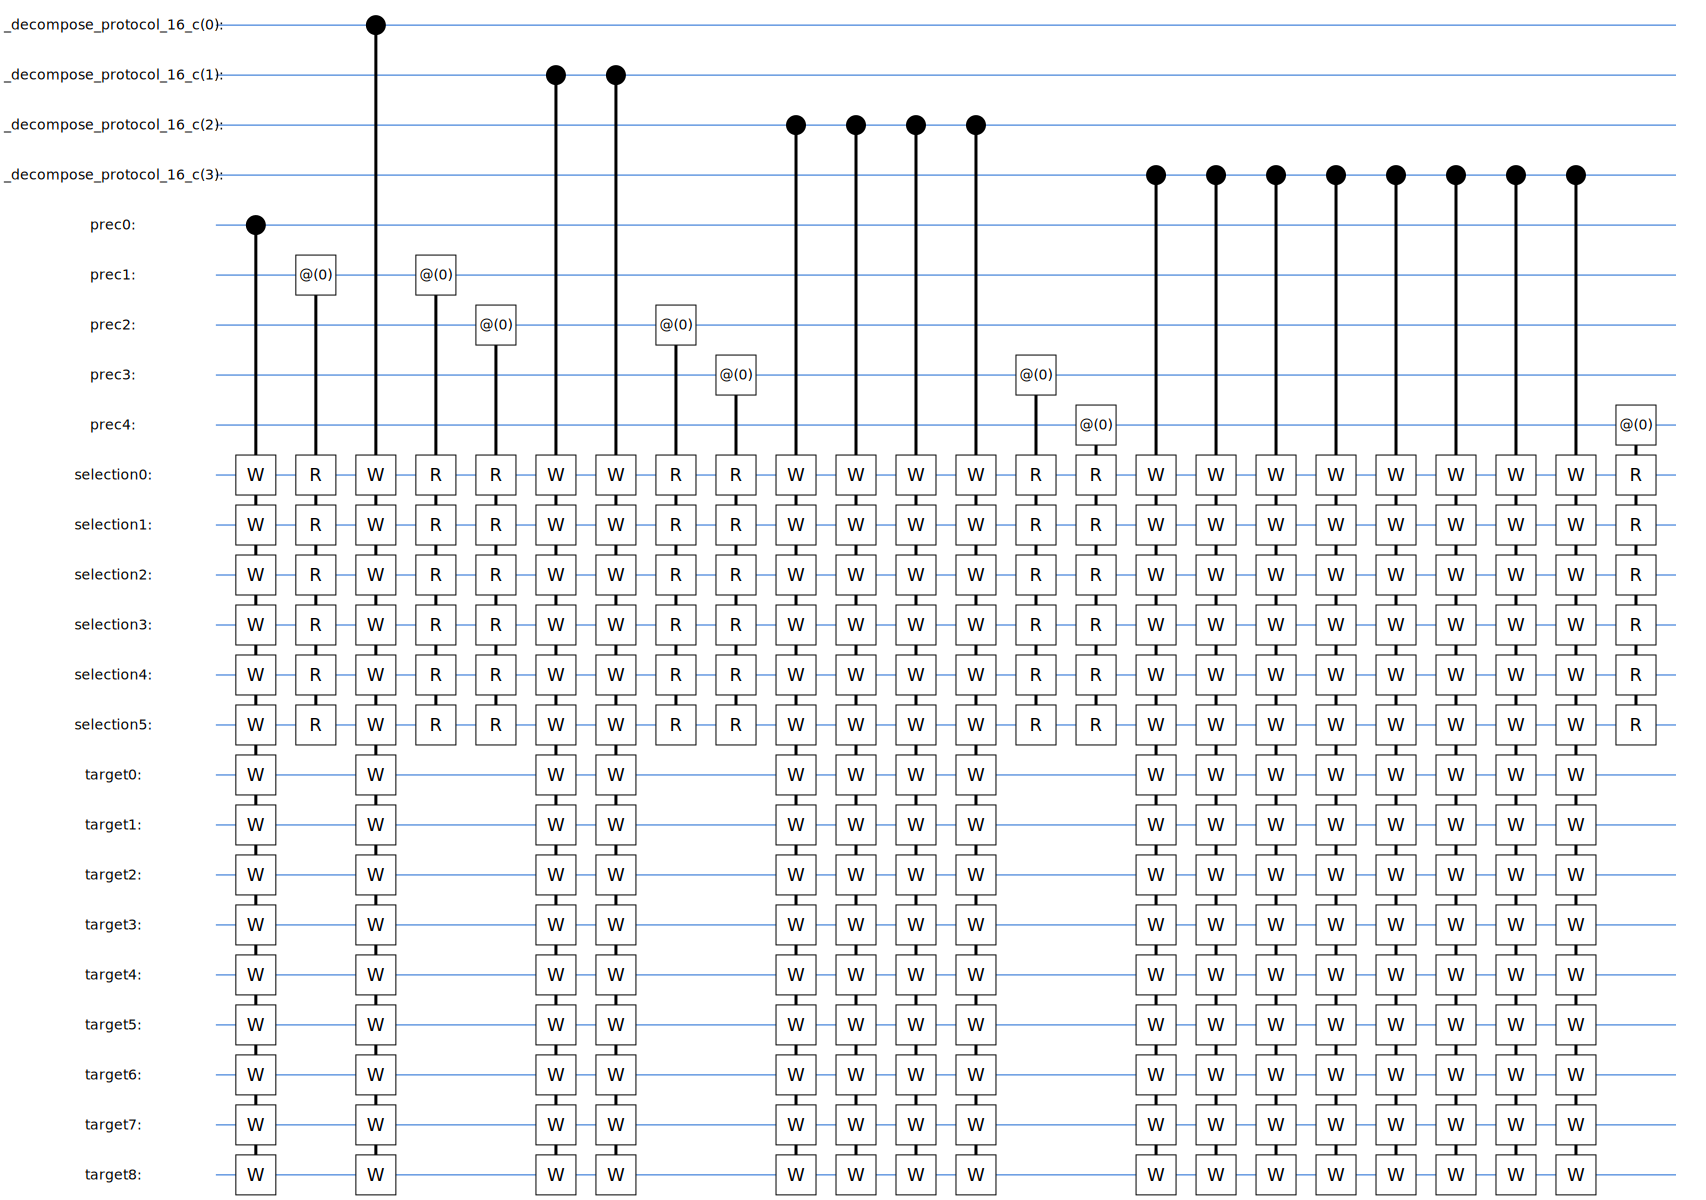

In [13]:
svg_circuit (circuit_decompose_multi(gate_gsee.circuit,1) )

<h4><b>4.2. GSEE Calculations: Scaling Analysis </b></h4> 

We now demonstrate GSEE resoure assessment for "utility-scale" Heisenberg model instances.  Our preceding examples  specified a fixed number of precision bits for the GSEE calculation.  We can instead specify a tolerance (`eps=`) for the error in eigenvalue estimation, which is far more useful in practice. The relative error in energy  will be taken as `eps = 1e-3`, which is suitable for many physical problems. 


<b>WARNING:</b> <i>The calculation block below can take roughly two hours to execute.  Precomputed outputs are provided after the block.</i>



In [14]:


# t_count         =   []
# logical_qubits  =   []

# problem_scale  = list([2**n for n in range(2,10)])
# problem_qubits = np.array(problem_scale)**2

# eps=1e-3

# for N in problem_scale:

#     model  =  getInstance( "Heisenberg", shape=(N,N), pbcs=(True,True), J=(J_x,J_y,J_z), 
#                            h=(h_x,h_y,h_z), cell=SquareLattice, )
    
#     gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.PauliLCU),
#                                             instance=model,eps=eps )
    
#     estimate = estimate_resources( gate_gsee )

#     t_count.append( estimate['T'] )
#     logical_qubits.append( estimate['LogicalQubits'] )



In [15]:
## Precomputed data
##

problem_scale  =   [  4,    8,   16,   32 ]
problem_qubits  =  [ 16,   64,  256, 1024 ]
logical_qubits  =  [ 36,   87,  282, 1054 ]
t_count         =  [104923712, 813892416, 6845629536, 112745514496]

Fit the data:

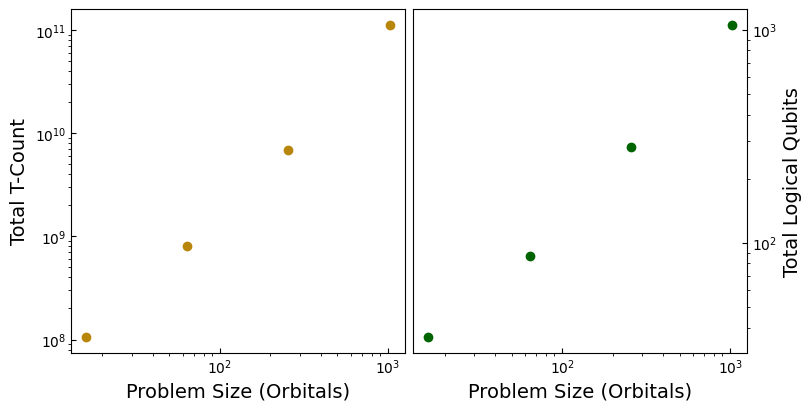

In [16]:
N_domain    =  np.linspace(problem_qubits[0],problem_qubits[-1], 100)

fig,ax = plt.subplots(1, 2, sharex=True,layout='constrained', figsize=(8, 4))

#ax[0].loglog(N_domain, fit_func_t_count(N_domain),linewidth=2,color='goldenrod')
ax[0].loglog(problem_qubits,t_count,'o',color='darkgoldenrod')
ax[0].tick_params(direction="in")
ax[0].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[0].set_ylabel('Total T-Count',fontsize=14);

#ax[1].loglog(N_domain, fit_func_logical_qubits(N_domain),linewidth=2,color='darkseagreen')
ax[1].loglog(problem_qubits,logical_qubits,'o',color='darkgreen')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(direction="in")
ax[1].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[1].set_ylabel('Total Logical Qubits',fontsize=14);


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [7]:
N_prec = 2
eps    = 1e-3

gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.PauliLCU),
                                      instance=model,prec=N_prec )

for ctr,line in enumerate(openqasm(gate_gsee.circuit,rotation_allowed=False)):
    if ctr < 100:
        print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [gancilla_c(0), gancilla_c(1), gancilla_c(2), gancilla_c(3), gancilla_c(4), gancilla_c(5), gancilla_c(6), gancilla_c(7), gancilla_c(8), gancilla_c(9), gancilla_c(10), gancilla_c(11), prec0, prec1, prec2, selection0, selection1, selection2, selection3, selection4, selection5, target0, target1, target2, target3, target4, target5, target6, target7, target8]
qreg q[30];


sdg q[15];
h q[15];
rz_d(pi*0.8533661356) q[15];
// (True, 40507356481889428083023830586, 97, [H, Z])
h q[15];
s q[15];
h q[2];
h q[6];
h q[3];
h q[4];
h q[7];
h q[5];
rz_d(pi*1.5) q[21];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[22];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[23];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[24];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[25];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[26];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[27];
// (False, 0, 0, [(S**-1)])
rz_d(pi*1.5) q[28];
// (Fals